# Step 3. Train the model (LSTM)

Using the data created from Step 1, here we are going to build a simple benchmark model (simple neural network) to evaluate the stock return predictability.

We find the model in Step 2 is barely the same as Random walk. Let's try whether a more complicated model, LSTM can be helpful.

In [1]:
# data 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

In [3]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

In [4]:
data_dir = 'data' # the folder we will use for storing data
name = 'train.csv'

In [5]:
# specify where to upload in S3
prefix = 'stock-price-predictor'

# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-ap-northeast-1-165829362107/stock-price-predictor


In [6]:
!pygmentize source_lstm/model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

# Here we define our model as a class
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_layer_size = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim)

        self.linear = nn.Linear(hidden_dim, output_dim)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

    def forward(self, input_seq):

        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))

        return predictions


In [7]:
!pygmentize source_lstm/train.py

from __future__ import print_function  # future proof
import argparse
import sys
import os
import json

import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

# import model
from model import SimpleLSTM

def model_fn(model_dir):
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleLSTM(model_info['input_dim'],
                      model_info['hidden_dim'],
                      model_info['output_dim'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'model.pth')
    with open(model_path, 'rb') as f:
     

## Train the Model

In [9]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source_lstm', # this should be just "source" for your code
                    role=role,
                    framework_version='1.3.1',
                    train_instance_count=1,
                    train_instance_type='ml.c4.8xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'input_dim': 46,  # num of features
                        'hidden_dim': 3,
                        'output_dim': 1,
                        'epochs': 10 # could change to higher
                    })

In [ ]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

2020-02-20 08:36:25 Starting - Starting the training job...
2020-02-20 08:36:27 Starting - Launching requested ML instances.........
2020-02-20 08:38:01 Starting - Preparing the instances for training...
2020-02-20 08:38:55 Downloading - Downloading input data...
2020-02-20 08:39:08 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-02-20 08:39:37,481 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-02-20 08:39:37,484 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-02-20 08:39:37,496 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-02-20 08:39:40,520 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-02-20 08:39:40,921 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2

## Deploy the Model

In [12]:
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.3.1',
                     entry_point='predict.py',
                     source_dir='source_lstm')

In [13]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 406 ms, sys: 16.3 ms, total: 423 ms
Wall time: 7min 33s


In [47]:
input_data = np.array(pd.read_csv("data/test.csv"))

X_test = input_data[:22, 1:]
y_test = input_data[:22, 0]

y_pred = predictor.predict(X_test)

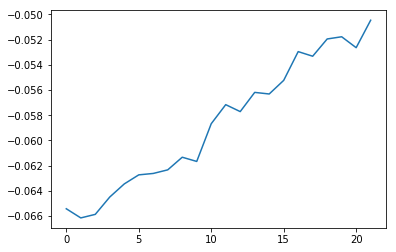

In [48]:
plt.plot(y_pred)

In [49]:
y_pred = y_pred.reshape(y_pred.shape[0])
y_test = y_test.reshape(y_pred.shape[0])

accuracy = ( np.logical_or( np.logical_and(y_pred >= 0, y_test >= 0),
                            np.logical_and(y_pred < 0, y_test < 0) ) ).sum() / len(y_test)
print("Accuracy =", accuracy)

Accuracy = 0.5909090909090909


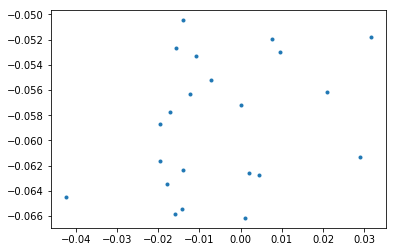

In [50]:
plt.figure()
plt.plot(y_test, y_pred, ls=' ', marker='.')
plt.show()

**Conclusion:**

By tests that are not listed here, if we try to forecast the entire test set (forecasting 4 years based on this simple model), then the performance is really poor: the accuaracy is only about 48% to 52%, and our model is always predicting negative numbers, so the accuracy actually only depends on how many returns are really negative.

One of the underlying problems, is that LSTM does not learn from the predicted output against the real output aggregately. In that way, the actual returns, essential for the data, did not get integrated with our model. Therefore, it's unlikely that our model still preverse long-term dependency. The model must learn from the output of each iteration of forecasting.

So our model may only be useful for short-term forecasting. Here I presented my methods when only forecasting 22 days, which is roughly the trading dates of a month. As we can see, my model predicts negative signs for all the returns in `GE`, and the actual accuracy is about 60%. This is a sign that my model says that this stock is not a good investment, and therefore it's always predicting negative signs. In fact, the actual returns have 60% of the times being negative.

It is therefore possible that the performance of my model has enhanced. However, more further steps need to be done for better analysis. For example, more high-frequency and up-to-date data, and better implement of model that can learn real-time, so the model can be useful in predicting long-term and it can keep learning.

In [46]:
# Accepts a predictor endpoint as input
# And deletes the endpoint by name
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [51]:
# delete the predictor endpoint 
delete_endpoint(predictor)

Deleted pytorch-inference-2020-02-20-09-15-31-886
